In [5]:
import torch
import torchvision
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# load the MNIST dataset
train = torchvision.datasets.MNIST(root='data', download=True)
test = torchvision.datasets.MNIST(root='data', train=False, download=True)

x_train = train.data.view(-1, 28 * 28).float().to(device)
y_train = torch.nn.functional.one_hot(train.targets).float().to(device)
x_test = test.data.view(-1, 28 * 28).float().to(device)
y_test = torch.nn.functional.one_hot(test.targets).float().to(device)

x_train.shape, x_test.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

In [3]:
x_train, x_test = x_test, x_train
y_train, y_test = y_test, y_train

Training model with 309510 parameters
Accuracy on the test set: 96.32%


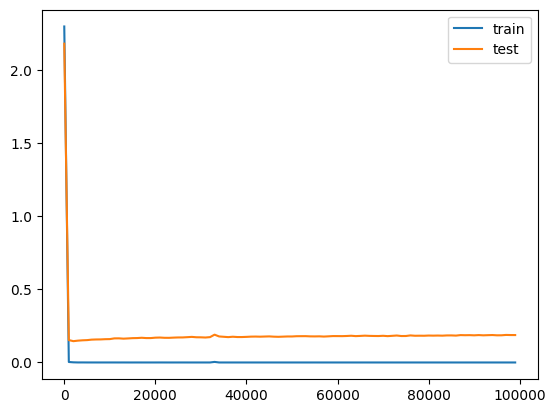

In [4]:
# initialize a deep neural network
model = torch.nn.Sequential(
	# input
	torch.nn.Linear(28 * 28, 300),
	torch.nn.ReLU(),
	# hidden
	torch.nn.Linear(300, 100, bias=False),
	torch.nn.BatchNorm1d(100),
	torch.nn.ReLU(),
	torch.nn.Linear(100, 100, bias=False),
	torch.nn.BatchNorm1d(100),
	torch.nn.ReLU(),
	torch.nn.Linear(100, 300, bias=False),
	torch.nn.BatchNorm1d(300),
	torch.nn.ReLU(),
	# output
	torch.nn.Linear(300, 10)
).to(device)

# train the model
print(f'Training model with {sum(p.numel() for p in model.parameters())} parameters')
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_losses, test_losses = [], []
for i in range(100000):
	batch_ix = torch.randint(0, x_train.shape[0], (128,))
	x_batch, y_batch = x_train[batch_ix], y_train[batch_ix]
	logits = model(x_batch)
	loss = torch.nn.functional.cross_entropy(logits, y_batch.argmax(dim=1))
	optimizer.zero_grad()
	loss.backward()
	optimizer.step()
	# stats
	if i % 1000 == 0:
		train_losses.append(loss.item())
		model.eval()
		logits = model(x_test)
		loss = torch.nn.functional.cross_entropy(logits, y_test.argmax(dim=1))
		test_losses.append(loss.item())
		model.train()

model.eval()  # <------------------- this is now needed for self.training in BatchNorm to work
accuracy = (model(x_test).argmax(dim=1) == y_test.argmax(dim=1)).float().mean().item()
print(f'Accuracy on the test set: {100 * accuracy:.2f}%')

iters = range(0, 100000, 1000)
plt.plot(iters, train_losses, label='train')
plt.plot(iters, test_losses, label='test')
plt.legend();